# Prepare

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.special import erf

In [ ]:
def trunc(x, f):
    return np.floor(x * 2**(-f))

def real_to_fixed(x, f):
    x_fixed = np.floor(x * 2**f)
    return x_fixed

def fixed_to_real(x, f):
    return x / 2**f

def linspace(a, b, f):
    return np.linspace(a, b-2**-f, (b-a)*2**f)

def lut_gen(func, a, b, f, q):
    """Create a Look Up Table for func.
    a: lower boundary
    b: upper boundary
    f: precision
    q: LUT size
    """
    x = linspace(a, b, q-int(np.log2(b-a)))
    value = real_to_fixed(func(x), f)
    return value

def lut_gen_smart(func, a, b, f, q):
    """Create a Look Up Table for func.
    a: lower boundary
    b: upper boundary
    f: precision
    q: LUT size
    """
    x = linspace(a, b, f)
    y = func(x)
    y_fixed = real_to_fixed(y, f)
    y_lut = []
    w = int(np.log2(b-a))+f-q
    print(f"{w=}, {q=}")
    for i in range(2**q):
        values = []
        for j in range(2**w):
            values.append(y_fixed[i*2**w+j])
        avg = np.round(np.average(values))
        y_lut.append(avg)
    return np.array(y_lut)

def lut_eval(x, lut):
    y = np.zeros_like(x)
    for i, e in enumerate(x):
        y[i] =  lut[int(e)]
    return y

In [ ]:
def subplot(ax, x, y, name):
    ax.plot(x, y)
    ax.set_title(name)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)

def plot(x, real, app):
    diff = real - app
    print(f"{max(abs(diff))=}")
    print(f"{sum(abs(diff))/len(diff)=}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2))
    subplot(ax1, x, diff, "Difference")
    subplot(ax2, x, app, "Evaluation")
    plt.show()

def experiment(func, a, b, f, q, n, wavelet):
    x = linspace(a, b, f)
    x_fixed = real_to_fixed(x, f)
    x_trunced = trunc(x_fixed, int(np.log2(b-a))+f - q)
    x_shifted = x_trunced - np.min(x_trunced)
    y = func(x)
    y_fixed = real_to_fixed(y, f)
    print("len of y (log2): ", np.floor(np.log(len(y))/np.log(2)))

    lut_dumb = lut_gen(func, a, b, f, q)
    print(f"LUT Size: {len(lut_dumb)}")
    print(len(x_shifted))
    y_lut_dumb = lut_eval(x_shifted, lut_dumb)
    plot(x, y_fixed, y_lut_dumb)

    lut_smart = lut_gen_smart(func, a, b, f, q)
    print(f"Smart LUT Size: {len(lut_smart)}")
    print(len(x_shifted))
    y_lut_smart = lut_eval(x_shifted, lut_smart)
    plot(x, y_fixed, y_lut_smart)

    coeffs = pywt.wavedec(y, wavelet, level=n)
    # Set detail coefficients at level m and higher to zero
    coeffs[0] = fixed_to_real(real_to_fixed(coeffs[0], f), f)
    for i in range(1, n+1):
        coeffs[i] = np.zeros_like(coeffs[i])
    # Reconstruct the approximation
    LUTsize = len(coeffs[0])
    print(f"DWT Size: {len(coeffs[0])}")
    y_hat = real_to_fixed(pywt.waverec(coeffs, wavelet), f)
    plot(x, y_fixed, y_hat)

    c = pywt.wavedec(y, wavelet, level=(int(np.log2(b-a))+f-q))
    c = c[0] * 2**((1-q)/2)
    print(int(np.log2(len(x))), (q-int(np.log2(len(x)))), ((q-int(np.log2(len(x))))//2))
    c = real_to_fixed(c, f)
    print(f"DWT LUT Size: {len(c)}")
    y_dwt = lut_eval(x_shifted, c)
    plot(x, y_fixed, y_dwt)

    diff = abs(y_fixed - y_hat)
    ave = sum(diff)/len(diff)
    return diff, ave, LUTsize


# Sigmoid

len of y (log2):  15.0
LUT Size: 256
32768
max(abs(diff))=32.0
sum(abs(diff))/len(diff)=7.65069580078125


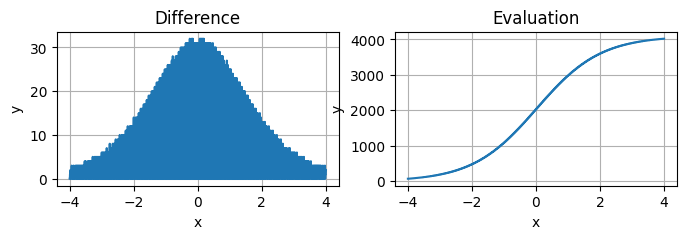

w=7, q=8
Smart LUT Size: 256
32768
max(abs(diff))=16.0
sum(abs(diff))/len(diff)=3.8551025390625


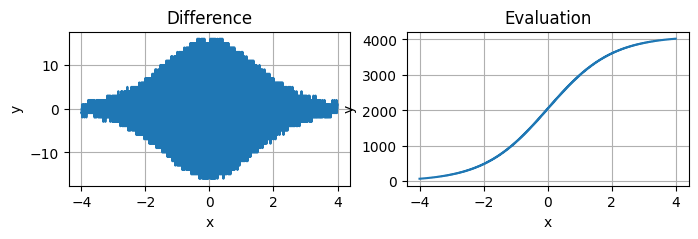

DWT Size: 256
max(abs(diff))=16.0
sum(abs(diff))/len(diff)=3.855224609375


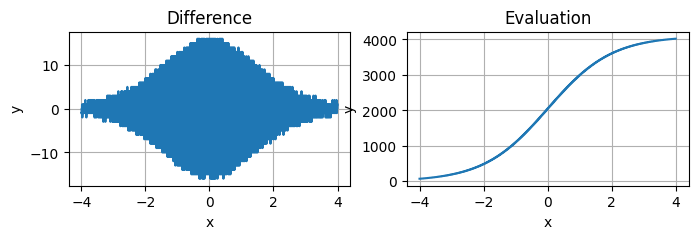

15 -7 -4
DWT LUT Size: 256
max(abs(diff))=16.0
sum(abs(diff))/len(diff)=3.8551025390625


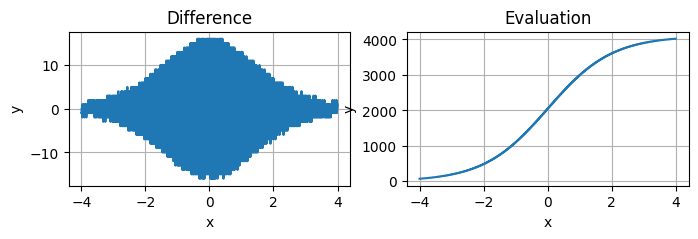

(array([1., 1., 1., ..., 1., 1., 1.]), 3.855224609375, 256)

In [ ]:
def Sigmoid(x, mean=0, std=1):
    return 1 / (1 + np.exp(-x))

experiment(Sigmoid,
            a = -4, # lower boundary
            b = 4, # upper boundary
            f = 12, # precision
            q = 8, # lookup table size
            n = 7, # wavelet depth
            wavelet = 'haar', # wavelet family
)

len of y (log2):  15.0
LUT Size: 512
max(diff)=16.0
sum(diff)/len(diff)=3.79522705078125


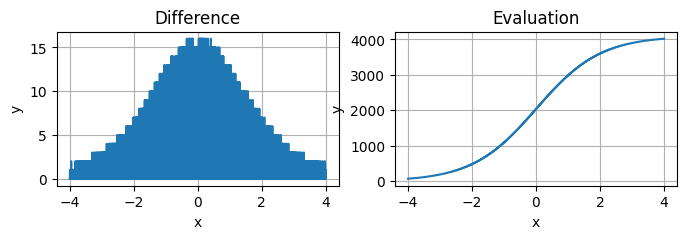

DWT LUT Size: 16
max(diff)=10.0
sum(diff)/len(diff)=2.798095703125


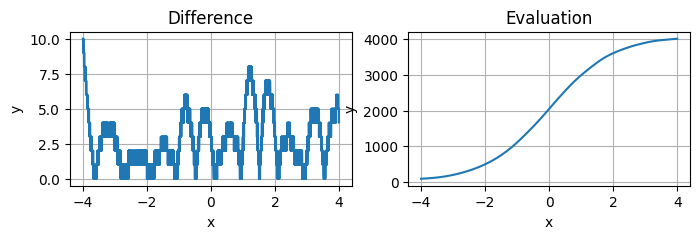

(array([10., 10., 10., ...,  5.,  5.,  5.]), 2.798095703125, 16)

In [ ]:
def Sigmoid(x, mean=0, std=1):
    return 1 / (1 + np.exp(-x))

experiment(Sigmoid,
            a = -4,
            b = 4,
            f = 12,
            q = 6,
            n = 12,
            wavelet = 'db5',
)

LUT Size: 128
max(abs(err))=64.0
8 15 -7
DWT LUT Size: 128
max(abs(err))=32.0


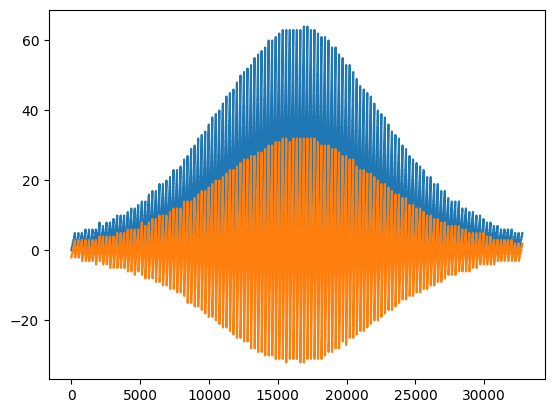

[ -2.  -2.  -2.  -3.  -3.  -3.  -3.  -4.  -3.  -4.  -4.  -5.  -5.  -5.
  -5.  -5.  -6.  -6.  -7.  -6.  -7.  -8.  -8.  -8.  -9.  -9. -10. -10.
 -11. -11. -12. -12. -13. -15. -15. -16. -16. -17. -18. -19. -19. -20.
 -21. -22. -22. -23. -24. -25. -25. -26. -26. -28. -28. -29. -29. -30.
 -30. -30. -31. -31. -31. -32. -31. -31. -31. -32. -32. -31. -31. -31.
 -31. -31. -30. -29. -29. -28. -28. -26. -27. -25. -25. -24. -23. -23.
 -22. -21. -20. -20. -19. -18. -17. -17. -16. -15. -14. -14. -13. -13.
 -12. -12. -11. -11. -10. -10.  -9.  -9.  -8.  -7.  -7.  -7.  -6.  -6.
  -6.  -6.  -5.  -5.  -4.  -4.  -4.  -4.  -4.  -3.  -3.  -3.  -3.  -3.
  -3.  -3.]


In [ ]:
import numpy as np
import pywt
from matplotlib import pyplot as plt

f = 12
x = linspace(-4, 4, f)
y = Sigmoid(x)
y_fixed = real_to_fixed(y, f)

q = 4
T = lut_gen(Sigmoid, -4, 4, f, q)
print(f"LUT Size: {len(T)}")
x_fixed = real_to_fixed(x, f)
x_trunced = trunc(x_fixed, f - q)
x_shifted = x_trunced - np.min(x_trunced)
y_lut = lut_eval(x_shifted, T)
err = y_fixed - y_lut
print(f"{max(abs(err))=}")
plt.plot(err)

wavelet = 'haar'
n = 8
err = []
coeffs = pywt.wavedec(y, wavelet, level=n)
c = coeffs[0] * 2**((n-f-3)//2)
print(n, f+3, n-f-3)
c = real_to_fixed(c, f)
print(f"DWT LUT Size: {len(c)}")
# for p in range(len(x)):
# for p in np.random.randint(0, len(x), 10):
    # eval = np.zeros(len(x))
    # eval[p] = 1
    # coeffs_x = pywt.wavedec(eval, wavelet, level=n)
    # the following works for haar only
    # sample = np.zeros(len(c))
    # sample[p >> -(n-f-4)] = 1 # 2**((n-f-3)//2)
    # app = np.dot(c, sample)
    # err.append(y_fixed[p]-app)

y_dwt = lut_eval(x_shifted, c)
err = y_fixed - y_dwt

err = np.array(err)
print(f"{max(abs(err))=}")
# print(f"{max(abs(real_to_fixed(err, f)))=}")
plt.plot(err)

plt.show()
print(T-c)

In [ ]:
x = linspace(-4, 4, 12)
y = Sigmoid(x)
y_fixed = real_to_fixed(y, 12)
y_i = y[0]
err = []
for i in range(2**7):
    values = []
    for j in range(2**8):
        values.append(y_fixed[i*2**7+j])
    avg = np.round(np.average(values))
    for v in values:
        err.append(avg - v)
print(max(np.abs(err)))

32.0


In [ ]:
import numpy as np
import pywt
from matplotlib import pyplot as plt

def linspace(a, b, f):
    return np.linspace(a, b-2**-f, (b-a)*2**f)

def real_to_fixed(x, f):
    x_fixed = np.floor(x * 2**f)
    return x_fixed

def Sigmoid(x, mean=0, std=1):
    return 1 / (1 + np.exp(-x))

def create_y_real(bit_width, table_bit_width):
    x_fixed_rational = np.array([i for i in range(0, 2**table_bit_width)]) * 2**(bit_width-table_bit_width)
    x_real = x_fixed_rational / 2**precision
    y_values = Sigmoid(x_real)
    return y_values

def create_quantized_lut(bit_width, precision, table_bit_width):
    y_values = create_y_real(bit_width, table_bit_width)
    y_fixed_rational = real_to_fixed(y_values, precision)
    return y_fixed_rational

def create_wavelet_lut(bit_width, precision, dwt_iterations):
    y_values = create_y_real(bit_width, bit_width)
    coeffs = pywt.wavedec(y_values, 'haar', level=dwt_iterations)
    dwt_lut_real = coeffs[0] # * 2**((dwt_iterations + 1 - bit_width)//2)
    dwt_lut_fixed = real_to_fixed(dwt_lut_real, precision)
    return dwt_lut_fixed

## would go from 0 to 2**(12) like 1/2**precision = 0.0625

bit_width = 8
precision = 4
table_bit_width = 6
dwt_iterations = 2

quantized_lut = create_quantized_lut(bit_width, precision, table_bit_width)
print(f"{len(quantized_lut)=}")
print(f"{quantized_lut=}")

dwt_lut = create_wavelet_lut(bit_width, precision, dwt_iterations)
print(f"{len(dwt_lut)=}")
print(f"{dwt_lut=}")

x = 132 # fixed rational
print(Sigmoid(x/2**precision))

x_look_up = x >> (bit_width - table_bit_width)
print(quantized_lut[x_look_up] / 2**precision)

x_one_hot = np.zeros((2**bit_width))
x_one_hot[x] = 1
x_dwt = pywt.wavedec(x_one_hot, 'haar', level=dwt_iterations)
print(x_dwt[0])
dwt_lookup = np.dot(dwt_lut, x_dwt[0])
print(dwt_lookup / 2**precision)

print(dwt_lut // 2 - quantized_lut)

len(quantized_lut)=64
quantized_lut=array([ 8.,  8.,  9., 10., 11., 12., 13., 13., 14., 14., 14., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.])
len(dwt_lut)=64
dwt_lut=array([16., 18., 20., 22., 23., 25., 26., 27., 28., 29., 29., 30., 30.,
       30., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.,
       31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31., 31.])
0.9997388096809043
0.9375
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

len of y (log2):  15.0
LUT Size: 512
max(abs(diff))=16.0
sum(abs(diff))/len(diff)=3.79522705078125


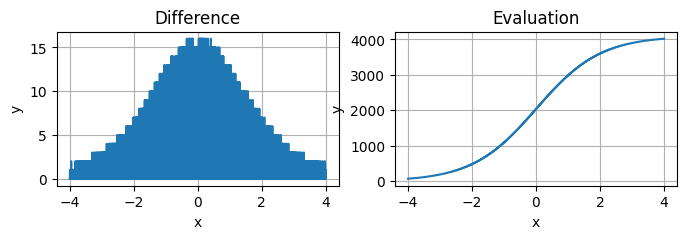

DWT LUT Size: 128
max(abs(diff))=32.0
sum(abs(diff))/len(diff)=7.7125244140625


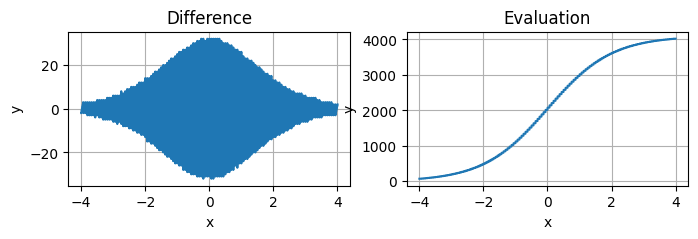

(array([2., 2., 2., ..., 2., 2., 2.]), 7.7125244140625, 128)

In [ ]:
def Sigmoid(x, mean=0, std=1):
    return 1 / (1 + np.exp(-x))

experiment(Sigmoid,
            a = -4,
            b = 4,
            f = 12,
            q = 6,
            n = 8,
            wavelet = 'haar',
)

# GeLU

len of y (log2):  14.0
LUT Size: 256
max(diff)=31.0
sum(diff)/len(diff)=2.69366455078125


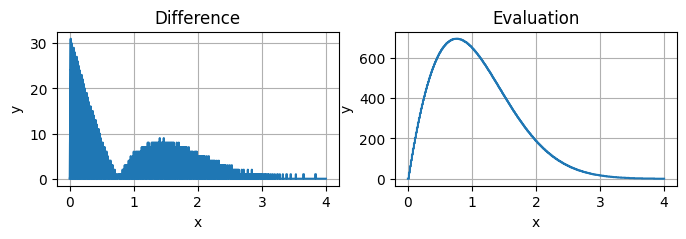

DWT LUT Size: 128
max(diff)=31.0
sum(diff)/len(diff)=2.73187255859375


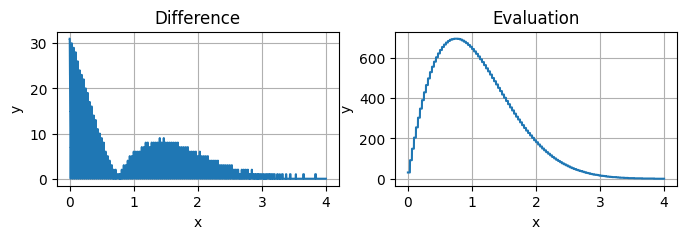

(array([31., 31., 31., ...,  0.,  0.,  0.]), 2.73187255859375, 128)

In [ ]:
def ReLU(x):
    return x * (x > 0)

def GeLU(x):
    y = 0.5 * x * (1 + erf(x / np.sqrt(2)))
    return y

def Delta(x):
    return ReLU(x) - GeLU(x)

experiment(Delta,
            a = 0,
            b = 4,
            f = 12,
            q = 6,
            n = 9,
            wavelet = 'db3',
)
# n=7, db1

# Reciprocal

len of y (log2):  16.0
LUT Size: 1024
max(diff)=63.0
sum(diff)/len(diff)=1.8802337646484375


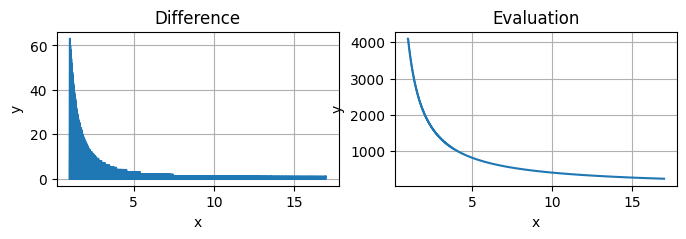

DWT LUT Size: 68
max(diff)=62.0
sum(diff)/len(diff)=0.8501739501953125


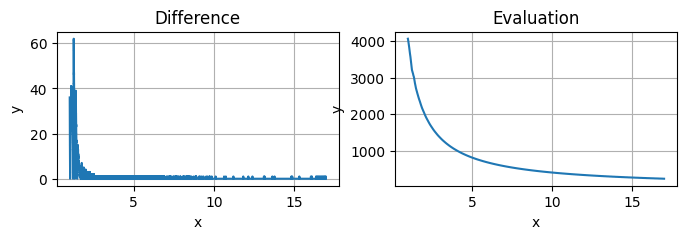

(array([36., 35., 34., ...,  0.,  0.,  0.]), 0.8501739501953125)

In [ ]:
def Reciprocal(x):
    return 1/x

experiment(Reciprocal,
            a = 1,
            b = 17, # softmax size
            f = 12,
            q = 6,
            n = 10,
            wavelet = 'db3',
)

# Inverse Square Root

LUT Size: 1044480
max(diff)=0.0
sum(diff)/len(diff)=0.0


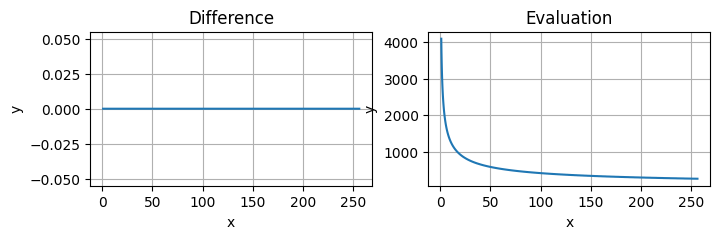

DWT LUT Size: 1050
max(diff)=49.0
sum(diff)/len(diff)=0.03322993259803922


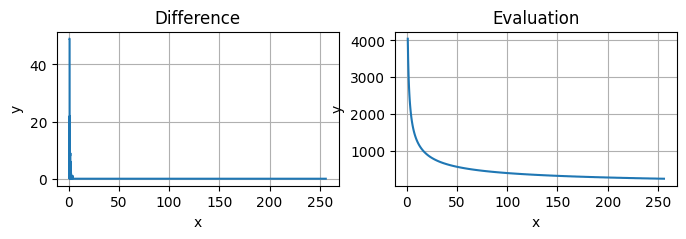

In [ ]:
def Normalize(x):
    return 1/np.sqrt(x)

experiment(Normalize,
            a = 1,
            b = 2**8,
            f = 12,
            q = 12,
            n = 10,
            wavelet = 'db16',
)

# Exponential

len of y (log2):  14.0
LUT Size: 256
max(diff)=63.0
sum(diff)/len(diff)=7.7535400390625


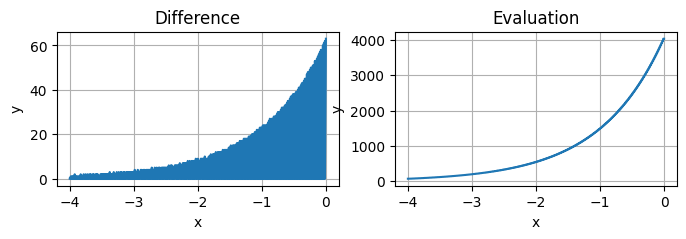

DWT LUT Size: 14
max(diff)=11.0
sum(diff)/len(diff)=1.1134033203125


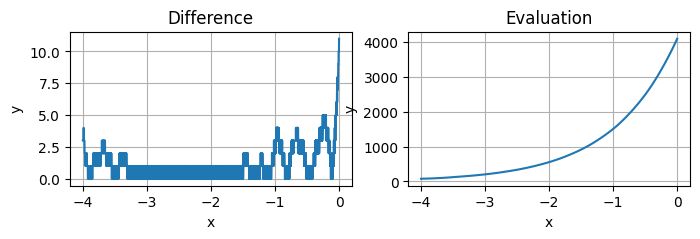

In [ ]:
def Exponential(x):
    return np.exp(x)

diff, ave = experiment(Exponential,
            a = -4,
            b = 0,
            f = 12,
            q = 6,
            n = 11,
            wavelet = 'db4',
)

# Daubechies Wavelet

Original level=6 and length=64
Target level J=4 and N=n-J: 2
Number of approximation coefficients: 18


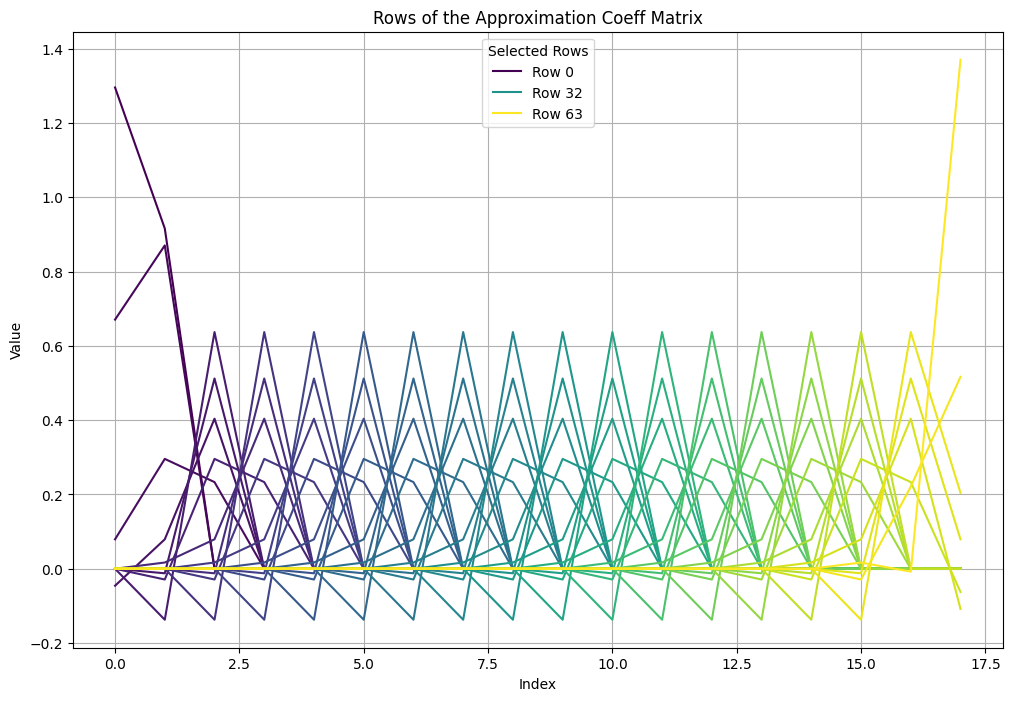

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
# Define the wavelet family
wav_fam = 'db2'
# works n=7 and J=3
n = 6
# Compute DWT at level J=3
J = 4
N = n - J
vector_length = 2**n

# Create a matrix with all one-hot vectors
one_hot_matrix = np.eye(vector_length)

# Iterate over each one-hot vector in the matrix
for k in range(len(one_hot_matrix)):
    one_hot_vector = one_hot_matrix[k, :]

    # Apply DWT at level N
    coeffs = pywt.wavedec(one_hot_vector, wav_fam, level=N)

    # Set detail coefficients at level N and higher to zero
    for i in range(1, N+1):
        coeffs[i] = np.zeros_like(coeffs[i])

    # Count non-zero coefficients before setting to zero
    if k==0:
      approx_matrix = np.zeros((len(one_hot_matrix), len(coeffs[0])))
      print(f"Original level={n} and length={vector_length}")
      print(f"Target level J={J} and N=n-J: {N}")
      print("Number of approximation coefficients:", len(coeffs[0]))

    # Apply the inverse DWT to obtain the reconstructed vector
    approx_matrix[k, :] = coeffs[0]


# Plot every row of the reconstructed_matrix in the same plot using different colours
plt.figure(figsize=(12, 8))

# Generate a color map to use different colors for each row
colors = plt.cm.viridis(np.linspace(0, 1, vector_length))

for i, row in enumerate(approx_matrix):
    #if i<10:
      plt.plot(row, color=colors[i], label=f'Row {i}' if i in [0, vector_length//2, vector_length-1] else "")

plt.title('Rows of the Approximation Coeff Matrix')
plt.xlabel('Index')
plt.ylabel('Value')
# Limiting the legend to only a few entries to avoid overcrowding
plt.legend(title="Selected Rows")
plt.grid(True)
plt.show()

0 (array([1, 2]),) [-0.01225953  0.51225953]
1 (array([1, 2]),) [-0.13725953  0.63725953]
2 (array([1, 2, 3]),) [-0.02900635  0.29575318  0.23325318]
3 (array([1, 2, 3]),) [0.01674682 0.07924682 0.40400635]
4 (array([2, 3]),) [-0.01225953  0.51225953]
[2, 2, 3, 3, 2]


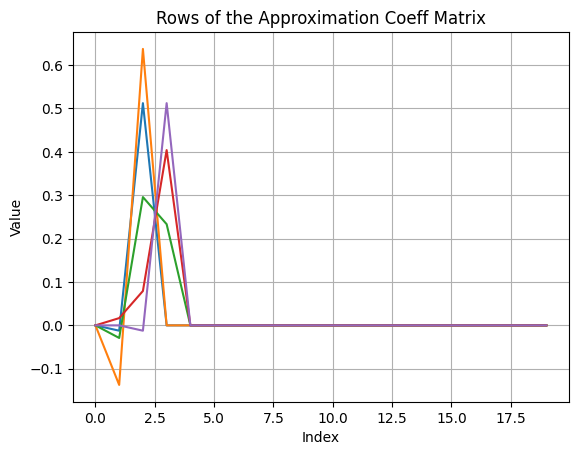

In [79]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
# Define the wavelet family
wav_fam = 'db2'
# works n=7 and J=3
n = 6
# Compute DWT at level J=3
J = 4
N = n - J
vector_length = 2**n

# Create a matrix with all one-hot vectors
one_hot_matrix = np.eye(vector_length)

# These hyperparameters are for handling boundary effects
A = 4
B = 6

nonzero = []
for k in range(5): #range(len(one_hot_matrix)):
    # Iterate over each one-hot vector in the matrix
    one_hot_vector = np.append(np.append(np.zeros((A, 1)), one_hot_matrix[k, :]), np.zeros((B, 1)))

    # Apply DWT at level N
    coeffs = pywt.wavedec(one_hot_vector, wav_fam, level=N)

    print(k, np.where(coeffs[0] != 0), coeffs[0][coeffs[0] != 0])

    nonzero.append(sum(coeffs[0] != 0))
    plt.plot(coeffs[0])
print(nonzero)

plt.title('Rows of the Approximation Coeff Matrix')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [63]:
0.40400635-0.23325318

0.17075317

In [75]:
pywt.wavelist(kind="discrete")

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',